## Playing with PUDL
This notebook is meant to help get you up and running with the PUDL database, so you can play with it!

### Importing external code.
We need to import a bunch of outside code to do our work here.  Sometimes we import entire packages (like `numpy` and `pandas`) and sometimes we just pull in a couple of pieces we need from a particular part of a large package (like `declarative_base`)

In [2]:
import sys
import os.path
import numpy as np
import pandas as pd
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.engine.url import URL
import matplotlib.pyplot as plt

### Importing our own code
We also need to tell Python where to look to find our own code.  It has a list of directories that it looks in, but our little project isn't in that list, unless we add it -- which is what `sys.path.append()` does.  You'll need to change this path to reflect where on your computer the PUDL project folder (which you pull down with `git`) lives.

Once Python knows to look in the `pudl` project folder, it will let you import `pudl` modules just like any other Python module.  Here we're pulling in the `ferc1` and `pudl` modules from the `pudl` package (which is a directory inside the `pudl` project directory).

In [3]:
sys.path.append('/Users/christinagosnell/code/pudl')
sys.path.append('/Users/zaneselvans/code/catalyst/pudl')
sys.path.append('/Users/Nannerz/Desktop/working/pudl/')
sys.path.append('/home/alana/Dropbox/catalyst/pudl')
from pudl import ferc1, pudl, models, models_ferc1, settings, constants

### Automatically reloading a work in progress
Because you're probably going to be editing the Python modules related to PUDL while you're working with this notebook, it's useful to have them get automatically reloaded before every cell is executed -- this means you're always using the freshest version of the module, with all your recent edits.

In [4]:
%load_ext autoreload
%autoreload 1
%aimport pudl.pudl
%aimport pudl.ferc1
%aimport pudl.constants
%aimport pudl.settings
%aimport pudl.models

### Connecting to our databases.
We have two different databases that we're working with right now.  The FERC Form 1 (`ferc1`) and our own PUDL database (`pudl`). For this software to work, you'll need to have the Postgresql database server running on your computer, and you'll need to have created empty databases to receive the tables and data we're going to create.  On a mac, the easiest Postgres install to get running is probably Postgress.app.  You'll need to fire it up at the command line at least once to create the databases (one called `ferc1` and another called `pudl_sandbox`) and a user named `catalyst` with no password.  This information is stored in the `settings` module if you need to look it up.

Here are two shortcuts for connecting to the two databases once they're created:

In [5]:
pudl_engine  = pudl.pudl.connect_db()
ferc1_engine = pudl.ferc1.connect_db()

### Initializing the FERC Form 1 database
Now that you've got an empty database, let's put some data in it!  This function initializes the database by reading in the FERC Form 1 database structure from `refyear` and data from `years` (which can eventually be a list of years, but that's not working yet...). In order for this to work, you need to have the FERC Form 1 data downloaded into the data directory. There's a script called `get_ferc1.sh` down in `data/ferc/form1/` that will get it for you if you don't have it.

In [6]:
pudl.ferc1.init_db(refyear=2015, years=[2007,2008,2009,2010,2011,2012,2013,2014,2015], ferc1_tables=pudl.constants.ferc1_default_tables)

Defining new FERC Form 1 DB based on 2015...
Clearing any existing FERC Form 1 database MetaData...
Ingesting FERC Form 1 Data from 2007...
Ingesting FERC Form 1 Data from 2008...
Ingesting FERC Form 1 Data from 2009...
Ingesting FERC Form 1 Data from 2010...
Ingesting FERC Form 1 Data from 2011...
Ingesting FERC Form 1 Data from 2012...
Ingesting FERC Form 1 Data from 2013...
Ingesting FERC Form 1 Data from 2014...
Ingesting FERC Form 1 Data from 2015...


### Initializing the PUDL database
We can also initialize the PUDL database now. Because we're messing around with it a lot, and playing with re-importing data over and over again, it's not a bad idea to destroy whatever old version of it exists in postgres (with `drop_tables`) and then re-create the tables anew (with `create_tables`).

Then we can actualy initialize some of the data (mostly glue tables connecting plants to utilities, and a few lists of constants like the US States for now) using `pudl.init_db()`. Eventually we'll need to tell this where to pull data from... but since we're not really putting any meaningful data into it yet, the function takes no arguments.

In [ ]:
pudl.pudl.drop_tables(pudl_engine)
pudl.pudl.create_tables(pudl_engine)
pudl.pudl.init_db()

In [7]:
pudl.pudl.init_db(ferc1_tables=['f1_fuel','f1_steam'], ferc1_years=[2007,2008,2009,2010,2011,2012,2013,2014,2015],\
                                  eia923_tables=[], eia923_years=[], debug=True)

Ingesting static PUDL tables...
Sniffing EIA923/FERC1 glue tables...
Ingesting f1_fuel from FERC Form 1 into PUDL.
Ingesting f1_steam from FERC Form 1 into PUDL.


### Pull applicable data from PUDL FERC tables

In [108]:
cost_per_mwh_f1 = pd.read_sql('''SELECT id, respondent_id, report_year, plant_name, fuel_cost_per_mwh, \
                                fuel_cost_per_mmbtu, fuel_avg_mmbtu_per_unit, fuel_qty_burned, fuel_unit, \
                                fuel_mmbtu_per_mwh, fuel \
                                FROM fuel_ferc1 WHERE plant_name <> '' ''',pudl_engine)

mwh_f1 = pd.read_sql('''SELECT respondent_id, report_year, plant_name, net_generation_mwh, total_capacity_mw, \
                                cost_per_mw, plant_kind \
                                FROM plants_steam_ferc1 WHERE plant_name <> '' ''', pudl_engine)

merged = pd.merge(cost_per_mwh_f1, mwh_f1, how='left', on=['report_year', 'respondent_id', 'plant_name'])

### Calculate capacity factor

In [115]:
merged['calculated_capacity_factor'] = merged['net_generation_mwh'] /(merged['total_capacity_mw']*8760)
merged['mmbtu'] = merged['fuel_mmbtu_per_mwh'] * merged['net_generation_mwh']
merged['calculated_heat_rate_fuel_kwh'] = merged['mmbtu']/( merged['net_generation_mwh'] * 1000)

In [116]:
merged.median()

id                               6.046500e+03
respondent_id                    1.190000e+02
report_year                      2.011000e+03
fuel_cost_per_mwh                2.800000e+01
fuel_cost_per_mmbtu              5.820000e+00
fuel_avg_mmbtu_per_unit          1.318330e+05
fuel_qty_burned                  1.268455e+05
fuel_mmbtu_per_mwh               8.670378e+06
net_generation_mwh               7.245550e+11
total_capacity_mw                3.125000e+02
cost_per_mw                      4.664980e+05
calculated_capacity_factor       3.448987e+05
mmbtu                            5.287380e+16
calculated_heat_rate_fuel_kwh    9.305000e+03
dtype: float64

### Plots of fuel costs (for values above zero, median fuel cost is 58 dollars per MWh)

In [71]:
positive_fuel = merged [ merged['fuel_cost_per_mwh'] > 0 ]
positive_fuel.fuel_cost_per_mwh.median()

58.0

In [92]:
positive_fuel.fuel_cost_per_mwh.std()

40084.219072194006

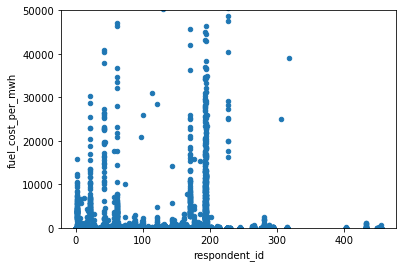

In [62]:
plot1 = cost_per_mwh_f1.plot.scatter(x='respondent_id', y='fuel_cost_per_mwh')
plot1.set_ylim(0,50000)
plt.show()

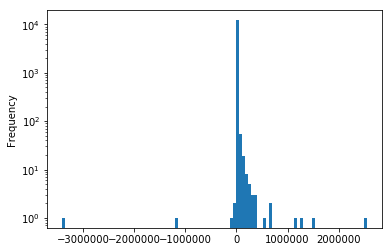

In [67]:
cost_per_mwh_f1['fuel_cost_per_mwh'].plot.hist(bins=100,logy=True)
plt.show()

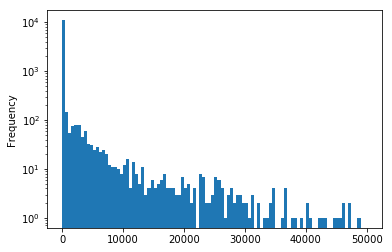

In [86]:
cost_per_mwh_f1['fuel_cost_per_mwh'].plot.hist(bins=100,logy=True,range=(0,50000))
plt.show()

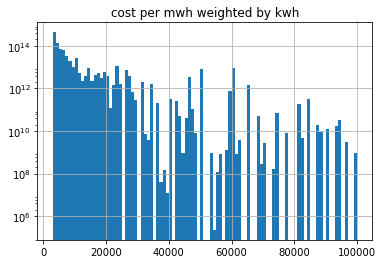

In [77]:
cost_kwh = merged['net_generation_mwh']

merged['fuel_cost_per_mwh'].hist(bins=100,log=True,range=(0,100000),weights=cost_kwh)
plt.title('cost per mwh weighted by kwh')
plt.show()

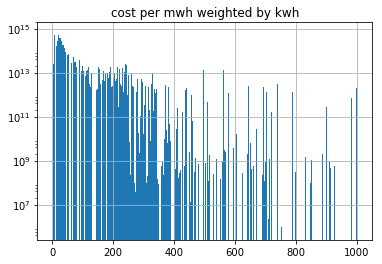

In [81]:
cost_kwh = merged['net_generation_mwh']

merged['fuel_cost_per_mwh'].hist(bins=1000,log=True,range=(0,1000),weights=cost_kwh)
plt.title('cost per mwh weighted by kwh')
plt.show()

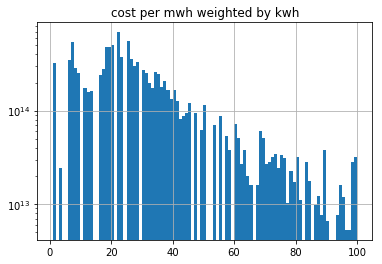

In [80]:
cost_kwh = merged['net_generation_mwh']

merged['fuel_cost_per_mwh'].hist(bins=100,log=True,range=(0,100),weights=cost_kwh)
plt.title('cost per mwh weighted by kwh')
plt.show()

### Taking a look at the heat rate (for values above zero, the median heat rate is 10900 mmbtu per kwh)

In [105]:
positive_heat_rate = merged [ merged['fuel_mmbtu_per_mwh'] > 0]
positive_heat_rate.fuel_mmbtu_per_mwh.median() / 1000

10900.0

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


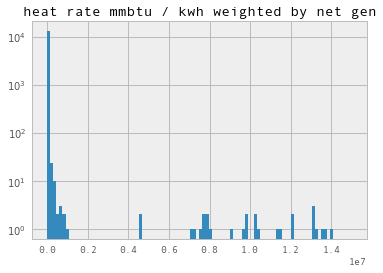

In [117]:
array_1 = merged['calculated_heat_rate_fuel_kwh']
plt.hist(array_1,bins=100,range=(0,15000000),log=True)
plt.title('heat rate mmbtu / kwh weighted by net gen')
plt.figure(figsize=(20,20),dpi=1000)
plt.show()

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


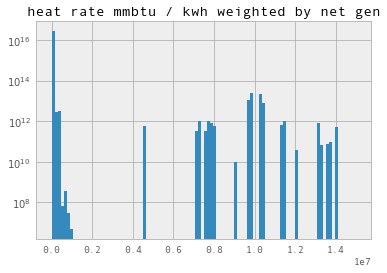

In [118]:
array_1 = merged['calculated_heat_rate_fuel_kwh']
array_2 = merged['net_generation_mwh']
plt.hist(array_1,bins=100,weights=array_2,range=(0,15000000),log=True)
plt.title('heat rate mmbtu / kwh weighted by net gen')
plt.figure(figsize=(20,20),dpi=1000)
plt.show()

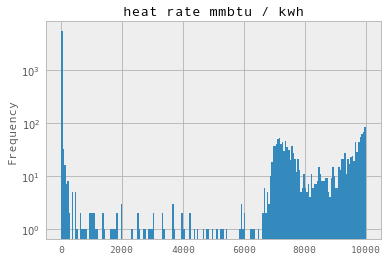

In [119]:
merged['calculated_heat_rate_fuel_kwh'].plot.hist(bins=200,logy=True,range=(0,10000))
plt.title('heat rate mmbtu / kwh')
plt.show()

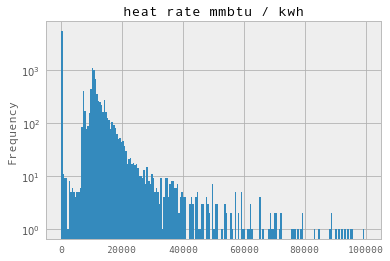

In [120]:
merged['calculated_heat_rate_fuel_kwh'].plot.hist(bins=200,logy=True,range=(0,100000))
plt.title('heat rate mmbtu / kwh')
plt.show()

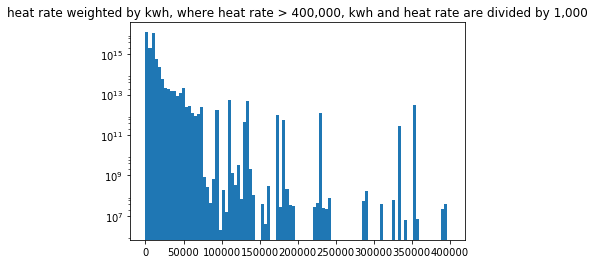

In [83]:
lower_heat_rate = merged[merged['calculated_heat_rate_fuel_kwh'] < 400000]
higher_heat_rate = merged[merged['calculated_heat_rate_fuel_kwh'] > 400000]
higher_heat_rate = higher_heat_rate[['calculated_heat_rate_fuel_kwh','net_generation_mwh']] * .0001
lower_heat_rate.append(higher_heat_rate)
heat_rate = lower_heat_rate['calculated_heat_rate_fuel_kwh']

kwh = lower_heat_rate['net_generation_mwh']

plt.hist(heat_rate,bins=100,weights=kwh,range=(0,400000),log=True)
plt.title('heat rate weighted by kwh, where heat rate > 400,000, kwh and heat rate are divided by 1,000')
plt.figure(figsize=(20,20),dpi=1000)
plt.show()

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4416: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  other.index).difference(self.columns).tolist()


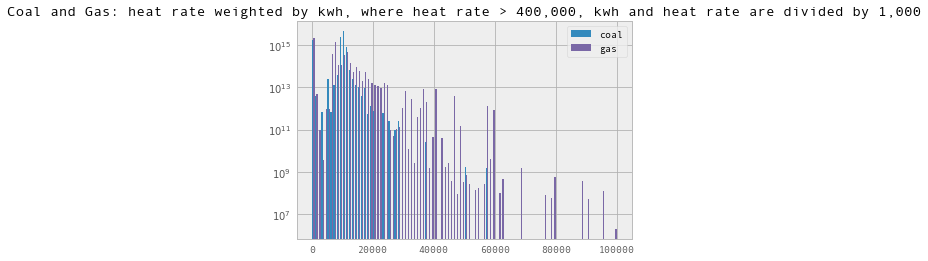

In [104]:
lower_heat_rate = merged[merged['calculated_heat_rate_fuel_kwh'] < 400000]
higher_heat_rate = merged[merged['calculated_heat_rate_fuel_kwh'] > 400000]
higher_heat_rate_gen_reduced = higher_heat_rate[['calculated_heat_rate_fuel_kwh','net_generation_mwh']] * .0001
higher_heat_rate_fuel = higher_heat_rate['fuel']

lower_heat_rate.append(higher_heat_rate_gen_reduced)
lower_heat_rate.append(higher_heat_rate_fuel)

coal_df = lower_heat_rate[lower_heat_rate['fuel'] == 'coal']
coal_heat_rate = coal_df['calculated_heat_rate_fuel_kwh']

gas_df = lower_heat_rate[lower_heat_rate['fuel'] == 'gas']
gas_heat_rate = gas_df['calculated_heat_rate_fuel_kwh']

kwh_coal = coal_df['net_generation_mwh']
kwh_gas = gas_df['net_generation_mwh']

plt.hist([coal_heat_rate,gas_heat_rate],bins=100,weights=[kwh_coal, kwh_gas],range=(0,100000),log=True,label=['coal','gas'])
plt.title('Coal and Gas: heat rate weighted by kwh, where heat rate > 400,000, kwh and heat rate are divided by 1,000')
plt.legend()

plt.show()

### Take a look at plants with very high heat rates to see if they're too high every year (they're not!).

In [21]:
higher_heat_rate = merged[merged['calculated_heat_rate_fuel_kwh'] > 400000]
higher_heat_rate.sort(columns='plant_name')

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,id,respondent_id,report_year,plant_name,fuel_cost_per_mwh,fuel_cost_per_mmbtu,fuel_avg_mmbtu_per_unit,fuel_qty_burned,fuel_unit,fuel_mmbtu_per_mwh,fuel,net_generation_mwh,total_capacity_mw,cost_per_mw,plant_kind,mmbtu,calculated_heat_rate_fuel_kwh,calculated_capacity_factor
9626,8758,147,2013,Afton Turbine,35.0,4.494,1.0,5059071.0,mcf,7.715519e+09,gas,6.997620e+11,230.00,943545.4,None,5.399027e+21,7.715519e+06,3.473109e+05
11734,10696,147,2014,Afton Turbine,43.0,5.360,1.0,4103714.0,mcf,8.015940e+09,gas,5.516960e+11,230.00,965125.3,None,4.422362e+21,8.015940e+06,2.738217e+05
8605,7802,147,2012,Afton Turbine,32.0,4.030,1028000.0,863253.0,mcf,7.896654e+09,gas,4.667250e+11,235.00,917126.6,None,3.685566e+21,7.896654e+06,2.267196e+05
665,623,2,2007,Barry,2420.0,2.434,11492.0,4803242.0,ton,9.691000e+09,coal,1.109939e+13,1770.80,373440.8,None,1.075642e+23,9.691000e+06,7.155264e+05
11209,10215,44,2014,Belle River (Oil),19698.0,20.510,136966.0,847.0,bbl,9.744000e+08,oil,5.000000e+06,13.75,247156.9,None,4.872000e+15,9.744000e+05,4.151100e+01
7619,6884,57,2011,Bowen No. 6,17732.0,21.209,138500.0,3880.0,bbl,8.360370e+08,oil,2.700000e+07,42.00,86053.1,None,2.257300e+16,8.360370e+05,7.338552e+01
8169,7413,144,2012,Connersville,14333.0,19.939,137000.0,625.0,bbl,7.188400e+08,oil,5.000000e+06,84.00,149834.5,None,3.594200e+15,7.188400e+05,6.794955e+00
6762,6115,27,2011,Dicks Creek,3120.0,5.974,1.0,27944.0,mcf,5.223070e+08,gas,5.500000e+07,159.00,145971.2,None,2.872688e+16,5.223070e+05,3.948767e+01
9732,8853,177,2013,Fairgrounds C.T.,15755.0,26.764,137000.0,1443.0,bbl,5.931709e+08,oil,1.400000e+07,68.30,91390.9,None,8.304392e+15,5.931709e+05,2.339932e+01
11588,10550,150,2014,Frederickson 1,35.0,4.939,1052000.0,2368486.0,mcf,7.185864e+09,gas,3.467429e+11,137.00,516125.4,None,2.491648e+21,7.185864e+06,2.889236e+05


In [22]:
merged[merged['plant_name'] == 'Afton Turbine']

,id,respondent_id,report_year,plant_name,fuel_cost_per_mwh,fuel_cost_per_mmbtu,fuel_avg_mmbtu_per_unit,fuel_qty_burned,fuel_unit,fuel_mmbtu_per_mwh,fuel,net_generation_mwh,total_capacity_mw,cost_per_mw,plant_kind,mmbtu,calculated_heat_rate_fuel_kwh,calculated_capacity_factor
636,596,147,2007,Afton Turbine,0.0,0.000,1027109.0,60442.0,mcf,1.098300e+07,gas,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2220,1994,147,2008,Afton Turbine,67.0,8.677,1027109.0,5737085.0,mcf,7.750000e+06,gas,7.606310e+11,141.0,1433262.0,None,5.894890e+18,7750.000,615815.764759
3565,3204,147,2009,Afton Turbine,24.0,3.221,975003.0,5117947.0,mcf,7.576543e+06,gas,6.754990e+11,235.0,881189.3,None,5.117947e+18,7576.543,328135.140387
4940,4452,147,2010,Afton Turbine,36.0,4.401,1023000.0,2256031.0,mcf,8.049948e+06,gas,2.867000e+11,235.0,918533.7,None,2.307920e+18,8049.948,139269.406393
6841,6183,147,2011,Afton Turbine,50.0,5.861,1023591.0,2341375.0,mcf,8.461427e+06,gas,2.849900e+11,235.0,921202.4,None,2.411422e+18,8461.427,138438.744778
8605,7802,147,2012,Afton Turbine,32.0,4.030,1028000.0,863253.0,mcf,7.896654e+09,gas,4.667250e+11,235.0,917126.6,None,3.685566e+21,7896654.000,226719.615273
9626,8758,147,2013,Afton Turbine,35.0,4.494,1.0,5059071.0,mcf,7.715519e+09,gas,6.997620e+11,230.0,943545.4,None,5.399027e+21,7715519.000,347310.899345
11734,10696,147,2014,Afton Turbine,43.0,5.360,1.0,4103714.0,mcf,8.015940e+09,gas,5.516960e+11,230.0,965125.3,None,4.422362e+21,8015940.000,273821.719277
12842,11729,147,2015,Afton Turbine,28.0,3.498,1.0,4653452.0,mcf,7.884500e+06,gas,6.467650e+11,141.0,1604918.6,None,5.099419e+18,7884.500,523628.517763


In [100]:
merged['plant_kind'].value_counts()

[autoreload of pudl.pudl failed: Traceback (most recent call last):
  File "/Users/Nannerz/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ModuleNotFoundError: No module named 'postgres_copy'
]


nuclear         333
photovoltaic      3
coal              2
Name: plant_kind, dtype: int64